<a href="https://colab.research.google.com/github/andyharless/covid19states/blob/master/covid_positive_rate_check.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import matplotlib.pyplot as plt

In [0]:
from google.colab import auth
auth.authenticate_user()
import gspread
from oauth2client.client import GoogleCredentials
gc = gspread.authorize(GoogleCredentials.get_application_default())

In [0]:
# Data from https://covidtracking.com
url = 'https://docs.google.com/spreadsheets/d/18oVRrHj3c183mHmq3m89_163yuYltLNlOmPerQ18E8w'

In [0]:
# Get data as a spreadsheet workbook
wb = gc.open_by_url(url)

In [0]:
# Get the sheet with daily data by state
data = wb.worksheet('States daily 4 pm ET').get_all_values()

In [6]:
# Convert to a Pandas DataFrame
full_df = pd.DataFrame(data)
full_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,Date,State,Positive,Negative,Pending,Hospitalized – Currently,Hospitalized – Cumulative,In ICU – Currently,In ICU – Cumulative,On Ventilator – Currently,On Ventilator – Cumulative,Recovered,Deaths
1,20200406,AK,191,"6,692",,,23,,,,,,6
2,20200406,AL,"1,968","12,797",,,240,,,,,,50
3,20200406,AR,875,"11,970",,74,130,,43,22,39,102,16
4,20200406,AS,0,20,11,,,,,,,,0


In [0]:
# Use the first row of data as column names
def set_first_row_as_header(df):
  new_header = df.iloc[0] # Grab the first row for the header
  df = df[1:]             # Take the data less the header row
  df.columns = new_header # Set the header row as the df header
  return(df)

In [0]:
# Convert data to the appropriate types
def convert_dtypes(df):
  for c in df.columns:
    if c=='Date':                   # 'Date' is a date
      df[c] = pd.to_datetime(df[c])  
    elif c=='State':                # 'State' is a string (default, so no action)
      pass                           
    else:                           # The rest are numeric, need to remove commas
      df[c] = pd.to_numeric(df[c].str.replace(',',''), errors='coerce')
  return(df)

In [0]:
# Proccess the data frames and calculate positive rates
full_df = set_first_row_as_header(full_df)
full_df = convert_dtypes(full_df)
full_df['Total'] = full_df.Positive+full_df.Negative.fillna(0)  # New definition
full_df['posrate'] = full_df.Positive / full_df.Total

In [10]:
# Find states with more than 1000 confirmed cases,
#   arranged in descending order of number of cases
current = full_df.sort_values(['Date', 'Positive'], ascending=False).head(50)
states = current[current.Positive>1000].State.values
states

array(['NY', 'NJ', 'MI', 'LA', 'CA', 'MA', 'FL', 'PA', 'IL', 'WA', 'GA',
       'TX', 'CT', 'CO', 'IN', 'OH', 'MD', 'TN', 'VA', 'NC', 'MO', 'AZ',
       'WI', 'SC', 'AL', 'NV', 'MS', 'UT', 'OK', 'ID', 'DC', 'RI', 'OR'],
      dtype=object)

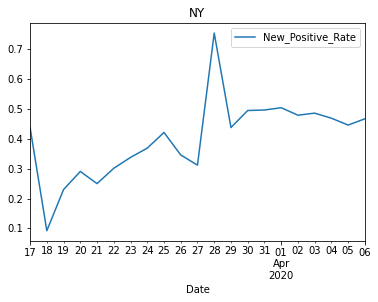

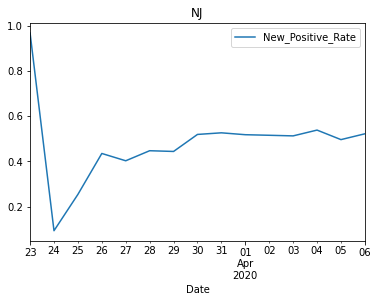

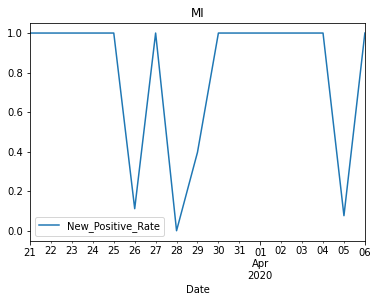

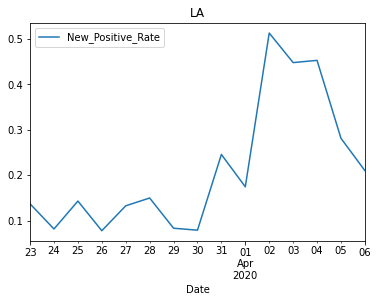

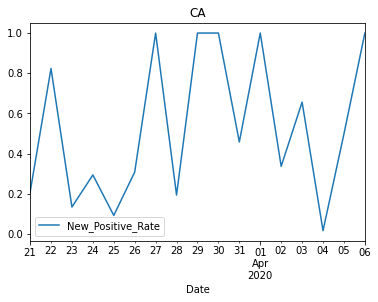

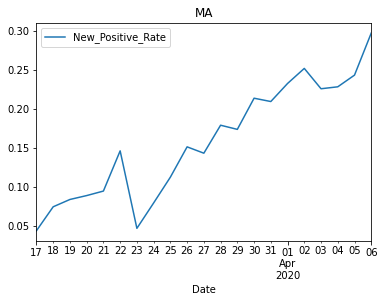

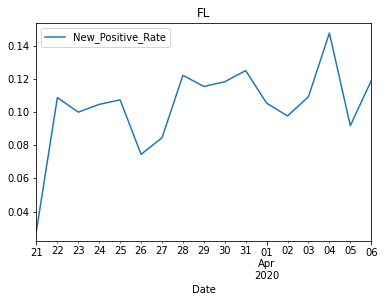

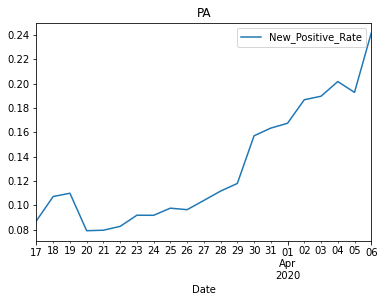

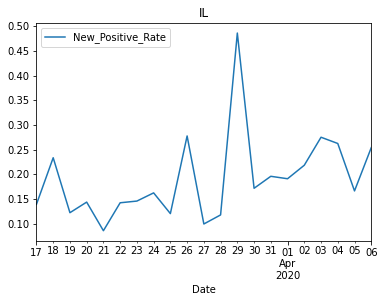

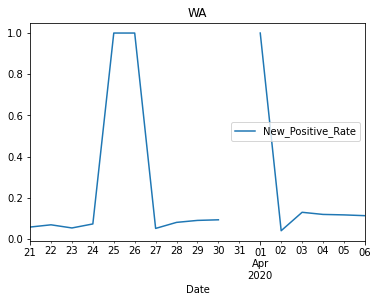

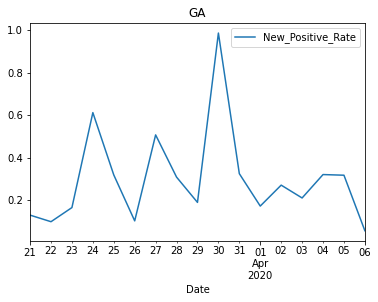

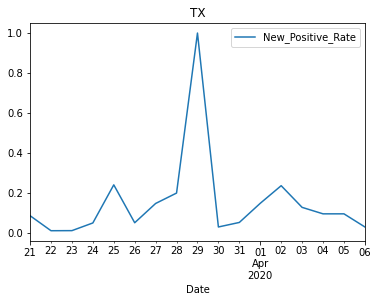

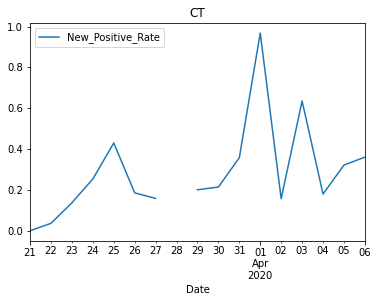

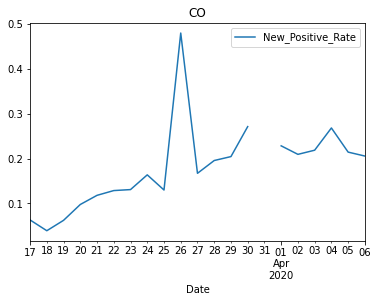

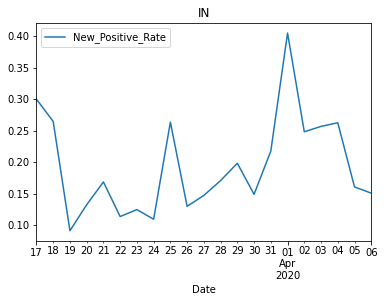

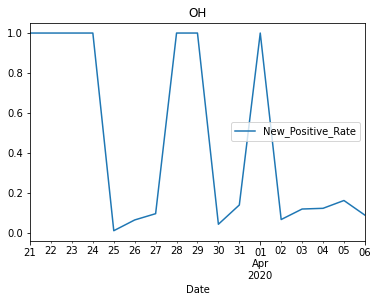

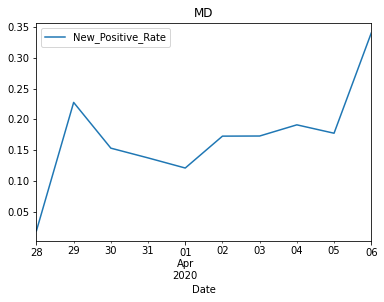

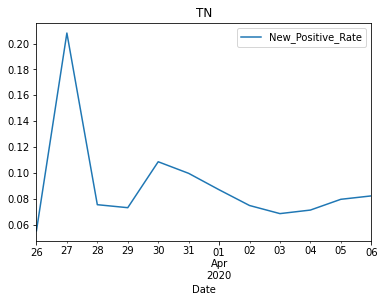

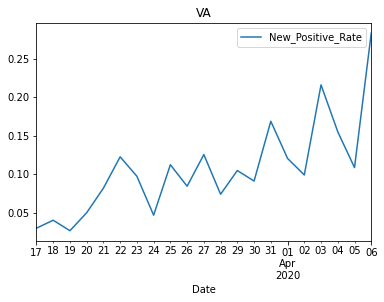

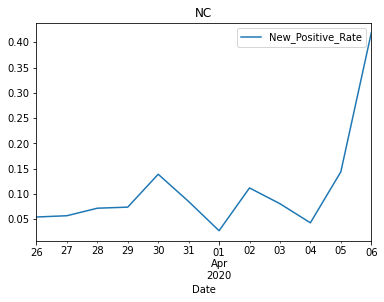

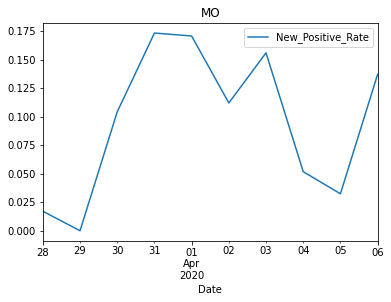

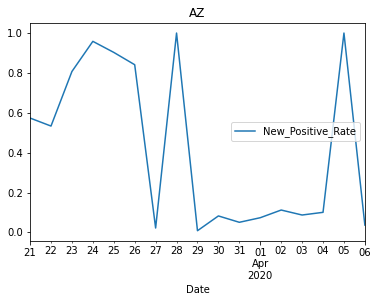

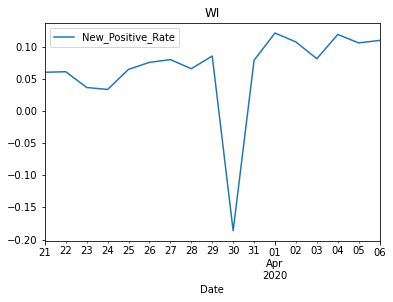

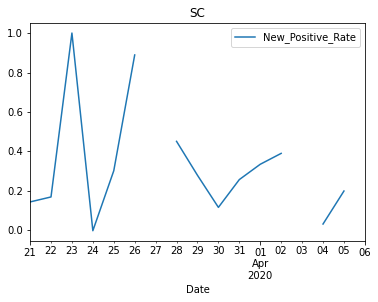

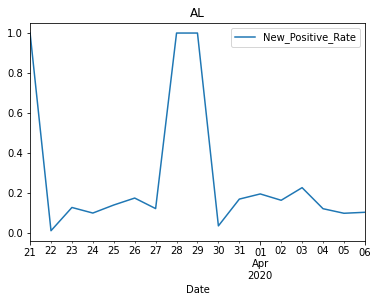

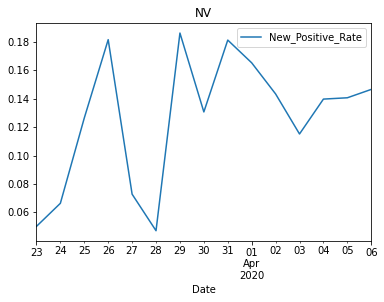

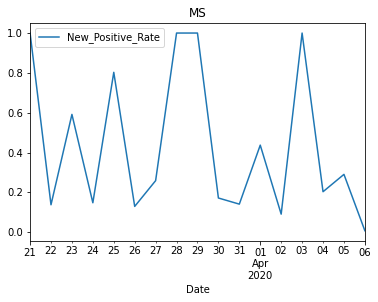

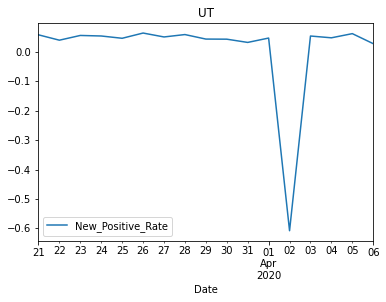

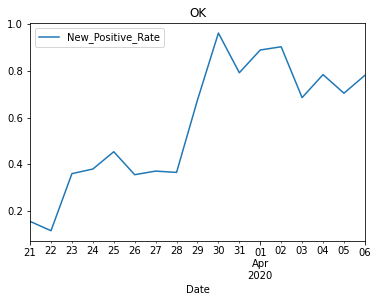

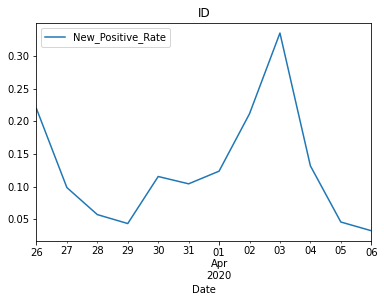

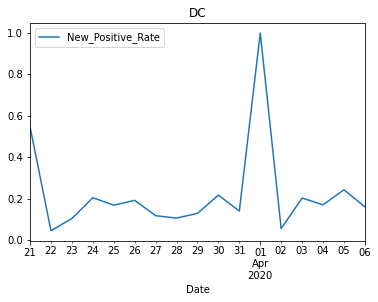

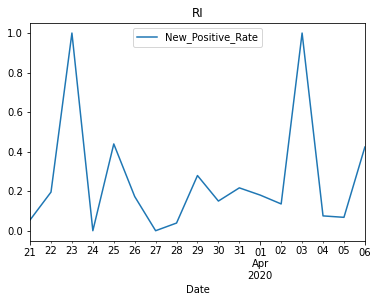

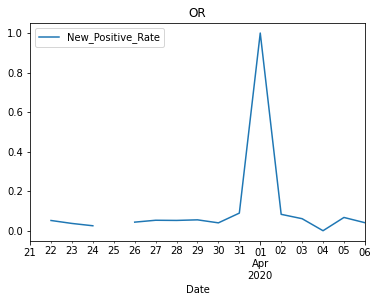

In [11]:
# Plot time series of fraction of NEW tests that are positive, by state,
#   with different start dates for different states, 
#   because positive rates stabilized at different times
for state in states:
  df = full_df[full_df.State==state].copy()
  df['New_Positives'] = -df['Positive'].diff().shift(-1)
  df['New_Negatives'] = -df['Negative'].diff().shift(-1)
  df['New_Positive_Rate'] = df.New_Positives / (df.New_Positives+df.New_Negatives.fillna(0))
  if state in ['NY', 'PA', 'MA', 'CO', 'IN', 'VA', 'IL', 'IN']:
    startdate = '2020-03-17'
  elif state in ['NJ', 'NV', 'LA']:
    startdate = '2020-03-23'
  elif state in ['ID', 'NC', 'TN']:
    startdate = '2020-03-26'
  elif state in ['MO', 'MD']:
    startdate = '2020-03-28'
  else:
    startdate = '2020-03-21'
  df[df.Date>=startdate][['Date',
                          'New_Positive_Rate']].set_index('Date'
                             ).plot(y='New_Positive_Rate', title=state)
  plt.show()

In [15]:
# Tabular results
for state in states:
  df = full_df[full_df.State==state].copy()
  df['New_Positives'] = -df['Positive'].diff().shift(-1)
  df['New_Negatives'] = -df['Negative'].diff().shift(-1)
  df['New_Positive_Rate'] = df.New_Positives / (df.New_Positives+df.New_Negatives.fillna(0))
  if state in ['NY', 'PA', 'MA', 'CO', 'IN', 'VA', 'IL', 'IN']:
    startdate = '2020-03-17'
  elif state in ['NJ', 'NV', 'LA']:
    startdate = '2020-03-23'
  elif state in ['ID', 'NC', 'TN']:
    startdate = '2020-03-26'
  elif state in ['MO', 'MD']:
    startdate = '2020-03-28'
  else:
    startdate = '2020-03-21'
  print('\n', state, df[df.Date>=startdate][['Date',
                          'New_Positive_Rate']].set_index('Date'))


 NY 0           New_Positive_Rate
Date                         
2020-04-06           0.467217
2020-04-05           0.446273
2020-04-04           0.469287
2020-04-03           0.486291
2020-04-02           0.479348
2020-04-01           0.504460
2020-03-31           0.496741
2020-03-30           0.495038
2020-03-29           0.438025
2020-03-28           0.754641
2020-03-27           0.311937
2020-03-26           0.346148
2020-03-25           0.421492
2020-03-24           0.369001
2020-03-23           0.337932
2020-03-22           0.301428
2020-03-21           0.250115
2020-03-20           0.290841
2020-03-19           0.230259
2020-03-18           0.092274
2020-03-17           0.437828

 NJ 0           New_Positive_Rate
Date                         
2020-04-06           0.522138
2020-04-05           0.496476
2020-04-04           0.538520
2020-04-03           0.512927
2020-04-02           0.515615
2020-04-01           0.518125
2020-03-31           0.526450
2020-03-30           0.519335
